In [1]:
import pandas as pd
import numpy as np

import collections

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [2]:
movie_md=pd.read_csv('data/movies_metadata.csv',low_memory=False)
movie_keywords=pd.read_csv('data/keywords.csv',low_memory=False)
movie_credits=pd.read_csv('data/credits.csv',low_memory=False)
ratings = pd.read_csv("data/ratings_small.csv")
print(movie_md.shape)

(45466, 24)


In [3]:
movie_md = movie_md[movie_md['vote_count']>=55]

# IDs of movies with count more than 55
movie_ids = [int(x) for x in movie_md['id'].values]

# Select ratings of movies with more than 55 counts
ratings = ratings[ratings['movieId'].isin(movie_ids)]

# Reset Index
ratings.reset_index(inplace=True, drop=True)

movie_md = movie_md[['id','original_title','overview','genres']]

movie_md['title'] = movie_md['original_title'].copy()

movie_md.reset_index(inplace=True, drop=True)

movie_credits = movie_credits[['id','cast']]

In [4]:
movie_credits.head()

,id,cast
0,862,"[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah..."
4,11862,"[{'cast_id': 1, 'character': 'George Banks', '..."


In [5]:
movie_md.head()

,id,original_title,overview,genres,title
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


## Data Cleaning & Preprocessing

In [6]:
movie_md = movie_md[movie_md['id'].str.isnumeric()]

movie_md['id'] = movie_md['id'].astype(int)

df = pd.merge(movie_md, movie_keywords, on='id', how='left')

df.reset_index(inplace=True, drop=True)

df = pd.merge(df, movie_credits, on='id', how='left')

df.reset_index(inplace=True, drop=True)

df.head()


,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '..."
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c..."
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '..."
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'cast_id': 25, 'character': 'Lt. Vincent Han..."


In [7]:
genres_list = []

df['genres'].apply(lambda x: [genres_list.append(i['name']) for i in eval(x)])

genres_frequency = collections.Counter(genres_list)

df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))
#Filling the nan values as []
df['keywords'].fillna('[]', inplace=True)

df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

#Filling the nan values as []

df['cast'].fillna('[]', inplace=True)

cast_list = []

df['cast'].apply(lambda x: [cast_list.append(i['name']) for i in eval(x)])

cast_frequency = collections.Counter(cast_list)

df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))
df.head()

,id,original_title,overview,genres,title,keywords,cast
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation Comedy Family,Toy Story,jealousy toy boy friendship friends rivalry bo...,TomHanks TimAllen DonRickles JimVarney Wallace...
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Adventure Fantasy Family,Jumanji,boardgame disappearance basedonchildren'sbook ...,RobinWilliams JonathanHyde KirstenDunst Bradle...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance Comedy,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmen,WalterMatthau JackLemmon Ann-Margret SophiaLor...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,Father of the Bride Part II,baby midlifecrisis confidence aging daughter m...,SteveMartin DianeKeaton MartinShort KimberlyWi...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...",Action Crime Drama Thriller,Heat,robbery detective bank obsession chase shootin...,AlPacino RobertDeNiro ValKilmer JonVoight TomS...


## merge all content/description of movies as a single feature

In [8]:
df['tags'] = df['overview'] + ' ' + df['genres'] +  ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

# Delete useless columns
df.drop(columns=['genres','overview','original_title','keywords','cast'], inplace=True)
df.head()

,id,title,tags
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ..."


In [9]:
df.isnull().sum()

df.drop(df[df['tags'].isnull()].index, inplace=True)
df.drop_duplicates(inplace=True)

In [10]:
tfidf = TfidfVectorizer(max_features=5000)
vectorized_data = tfidf.fit_transform(df['tags'].values)
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['tags'].index.tolist())

#Perform Dimension Reduction¶
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_dataframe)

# Print the shape
print(reduced_data.shape)


#Compute a similarity metric on vectors for recommendation
similarity = cosine_similarity(reduced_data)

(8595, 3000)


In [11]:
# Making recommendations for a given movie
def recommendation(movie_title):
    id_of_movie = df[df['title'] == movie_title].index[0]
    distances = similarity[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:10]

    for i in movie_list:
        print(df.iloc[i[0]].title)

print(recommendation('The Shawshank Redemption'))

Brubaker
杀破狼2
In Hell
A Christmas Story
Un prophète
The Samaritan
Dark Passage
Lock Up
Rosewater
None


In [12]:
#We will merge the movies and credits dataframes and select the columns which are required and have a unified movies dataframe to work on.
movie_md['genres'] = movie_md['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movie_md['genres'] = movie_md['genres'].str.split(',')

In [13]:
#check the movie_md.columns columns
movie_md.columns

Index(['id', 'original_title', 'overview', 'genres', 'title'], dtype='object')

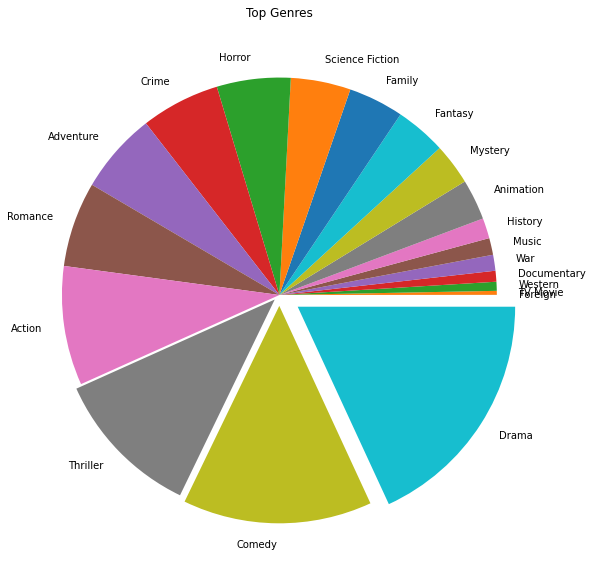

In [15]:
plt.figure(figsize=(12,10))

top_genre_names, top_genre_frequency = zip(*{k: v for k, v in sorted(genres_frequency.items(), key=lambda item: item[1])}.items())

explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.05, 0.1)

plt.pie(top_genre_frequency, labels=top_genre_names, explode=explode)
plt.title('Top Genres')
plt.show()

Drama appears to be the most popular genre followed by Comedy

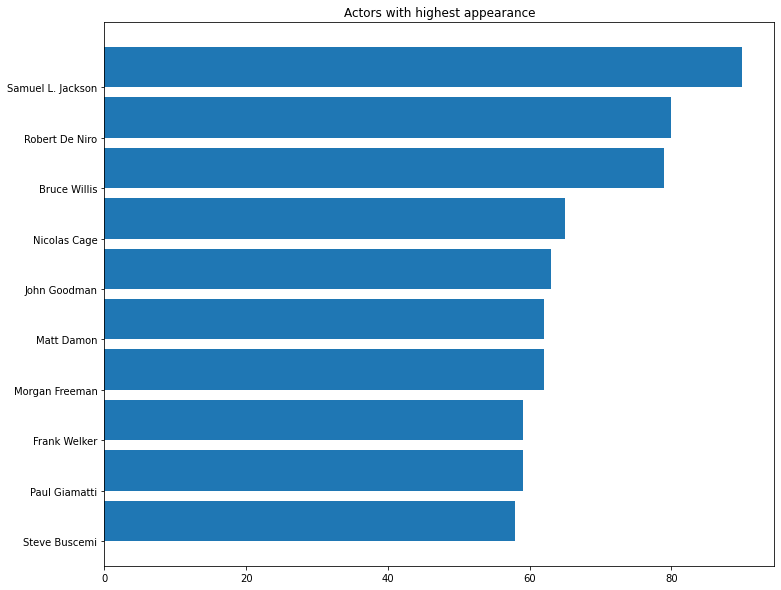

In [16]:
plt.figure(figsize=(12,10))
top_cast_names, top_cast_frequency = zip(*{k: v for k, v in sorted(cast_frequency.items(), key=lambda item: item[1])}.items())

plt.barh(y=top_cast_names[-10:], width=top_cast_frequency[-10:], align='edge')

plt.title('Actors with highest appearance')
plt.show()

In [17]:
# TODO: add original_languages frequency, popularity against budget, average_vote against budget visualization

In [18]:
from surprise import Dataset, Reader
from surprise.prediction_algorithms.knns import KNNBasic

In [19]:
# Initialize a surprise reader object
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# Load the data
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

# Build trainset object(perform this only when you are using whole dataset to train)
trainset = data.build_full_trainset()

In [20]:
#Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find similar items
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user.fit(trainset);

In [21]:
sim_user.predict(uid=2,iid=17,r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=4.166335018545322, details={'actual_k': 40, 'was_impossible': False})

In [22]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those product ids which the user_id has not interacted yet
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        movie_name = movie_md[movie_md['id']==str(item_id)]['title'].values[0]
        recommendations.append((movie_name, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [23]:
get_recommendations(ratings, movie_md, 671, 10, sim_user)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import pickle

# save the model to disk
filename = 'recommendation_model.sav'
pickle.dump(sim_user, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
get_recommendations(ratings, movie_md, 671, 10, loaded_model)